## Import

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

print(tf.__version__)
print(tfp.__version__)

1.13.0-rc0
0.5.0


モジュール名を定義

In [0]:
tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels#半正定値のカーネル

## Set Data

In [0]:
observation_noise_variance = 0.5

def f(x):
    return (np.sin(10*x[...,0])) + np.cos(5*x[...,0]) * np.exp(-x[...,0]**2)

observation_index_points = np.random.uniform(-1.,1.,50)[...,np.newaxis]
observations = (f(observation_index_points) + np.random.normal(0.,np.sqrt(observation_noise_variance)))

## Plot Data

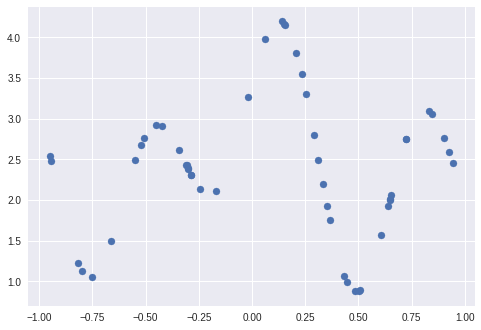

In [34]:
plt.scatter(observation_index_points,observations)

## Non parametric Gaussian process

In [0]:
index_points = np.linspace(-1.,1.,200)[...,np.newaxis]

kernel = psd_kernels.MaternFiveHalves()

gprm = tfd.GaussianProcessRegressionModel(
    kernel = kernel,
    index_points = index_points,
    observation_index_points = observation_index_points,
    observations = observations,
    observation_noise_variance = observation_noise_variance)

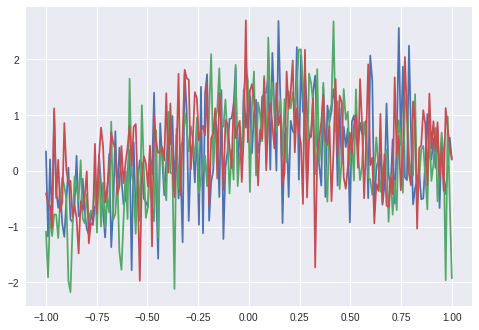

In [24]:
sample_gprm = gprm.sample(10)
with tf.Session() as sess:
    sample_gprm_ = sess.run(sample_gprm)
    for i in range(3):
        plt.plot(index_points, sample_gprm_[i])

## Gaussian Process Model

In [26]:
amplitude = tf.exp(tf.Variable(np.float64(0)),name = 'amplitude')
length_scale = tf.exp(tf.Variable(np.float64(0)),name = 'length_scale')

kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

Instructions for updating:
Colocations handled automatically by placer.


ExponentiatedQuadraticは次のような形のGauss形のカーネルのこと:
\begin{equation}
k(x_{i},x_{j}) = a\exp\left(-\dfrac{|x_i - x_j|^{2}}{2s^{2}}\right)
\end{equation}
ここで、変数$a$はamplitude, 変数$s$はlength_scaleと呼ばれている。

ここまでで、Guass分布に従う目的変数の平均値を与える事前分布の導入ができたことになる。

又、目的変数の従うGauss分布の分散も次のように定義しておくことにする。

In [0]:
observation_noise_variance = tf.exp(tf.Variable(np.float64(-5)),name = 'observation_noise_varinace')

Gauss過程を表すモデル:GaussianProcessにこれらの変数を代入し、モデルを定義する:

In [0]:
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points = observation_index_points,
    observation_noise_variance = observation_noise_variance)

## Set Loss function

Tensorflow_Probabilityでは、対数尤度をモデルに対して.log_probメソッドを用いることで、観測データを与えるだけで簡単に計算することが可能。

In [30]:
neg_log_likelihood = -gp.log_prob(observations)

optimizer = tf.train.AdamOptimizer(learning_rate=.05, beta1=.5, beta2=.99)
optimize = optimizer.minimize(neg_log_likelihood)

Instructions for updating:
Use tf.cast instead.


## Sampler

In [0]:
index_points = np.linspace(-1.5, 1.5, 200)[..., np.newaxis]
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10)

## Learning

Final NLL = -189.8772506992504


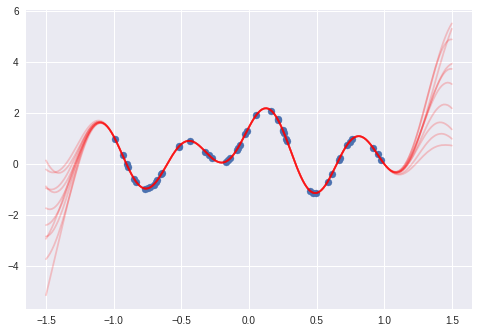

In [32]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1000):
        _, neg_log_likelihood_ = sess.run([optimize, neg_log_likelihood])
    if i % 100 == 0:
        print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

    print("Final NLL = {}".format(neg_log_likelihood_))
    samples_ = sess.run(samples)

    plt.scatter(np.squeeze(observation_index_points), observations)
    plt.plot(np.stack([index_points[:, 0]]*10).T, samples_.T, c='r', alpha=.2)